In [35]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=False)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

# plt.rc('font', family='Arial', size=12)
# plt.rc('axes', titlesize=16, labelsize=14, grid=True)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=18, frameon=False)
plt.rc('xtick', labelsize=14, direction='in')
plt.rc('ytick', labelsize=14, direction='in')
plt.rc('figure', figsize=(6, 4), dpi=100)

In [36]:
import shutil
import os
import sys

os.chdir('/home/zongchen/nest_bq/results/bo/ackley/')
dirs = []
for d in os.listdir('.'):
    dirs.append(d)

print(dirs)

['EI_look_ahead_mc__dim_5__N_25__kernel_rbf__seed_0', 'EI_look_ahead_mc__dim_2__N_25__kernel_rbf__seed_1', 'EI_look_ahead_mc__dim_2__N_25__kernel_rbf__seed_0', 'EI_look_ahead_kq__dim_2__N_25__kernel_rbf__seed_2', 'EI_look_ahead_kq__dim_2__N_25__kernel_rbf__seed_0', 'EI_look_ahead_kq__dim_2__N_25__kernel_matern__seed_2', 'EI_look_ahead_kq__dim_2__N_25__kernel_rbf__seed_1', 'EI_look_ahead_kq__dim_2__N_25__kernel_matern__seed_0', 'EI_look_ahead_mc__dim_2__N_25__kernel_rbf__seed_2', 'EI_look_ahead_kq__dim_2__N_25__kernel_matern__seed_1', 'EI_look_ahead_kq__dim_5__N_25__kernel_rbf__seed_0', 'EI_look_ahead_kq__dim_5__N_25__kernel_matern__seed_0']


In [37]:
# Arrays to store the I_nkq and I_nmc values
iter_num = 30
seed_num = len(dirs) / 3
I_nkq_values_array = None
I_nmc_values_array = None

dim = 2

# Loop over seed numbers and load data
for d in dirs:
    if 'EI_look_ahead_kq' in d and 'kernel_rbf' in d and f'dim_{dim}' in d:
        if I_nkq_values_array is None:
            I_nkq_values_array = np.load(f"{d}/bo_nmse.npy", 'r') 
        else:
            I_nkq_values_array = np.vstack((I_nkq_values_array, np.load(f"{d}/bo_nmse.npy", 'r')))

    if 'EI_look_ahead_mc' in d and f'dim_{dim}' in d:
        if I_nmc_values_array is None:
            I_nmc_values_array = np.load(f"{d}/bo_nmse.npy", 'r') 
        else:
            I_nmc_values_array = np.vstack((I_nmc_values_array, np.load(f"{d}/bo_nmse.npy", 'r')))

# Compute the median and standard deviation
I_nkq_median = np.median(I_nkq_values_array, axis=0)
I_nkq_q25 = np.percentile(I_nkq_values_array, 25, axis=0)
I_nkq_q75 = np.percentile(I_nkq_values_array, 75, axis=0)

I_nmc_median = np.median(I_nmc_values_array, axis=0)
I_nmc_q25 = np.percentile(I_nmc_values_array, 25, axis=0)
I_nmc_q75 = np.percentile(I_nmc_values_array, 75, axis=0)



In [38]:
I_nkq_values_array

array([[1.        , 1.        , 1.        , 0.68824072, 0.68824072,
        0.68824072, 0.30970332, 0.30970332, 0.30970332, 0.30970332,
        0.30970332, 0.30970332, 0.30970332, 0.30970332, 0.30970332,
        0.30970332, 0.30970332, 0.30970332, 0.30970332, 0.30970332,
        0.30970332, 0.30970332, 0.30970332, 0.30970332, 0.30970332,
        0.30970332, 0.23864231, 0.23864231, 0.23864231, 0.12761626],
       [1.        , 1.        , 0.26650224, 0.26650224, 0.26650224,
        0.25026465, 0.25026465, 0.25026465, 0.25026465, 0.25026465,
        0.25026465, 0.25026465, 0.25026465, 0.25026465, 0.25026465,
        0.25026465, 0.25026465, 0.25026465, 0.25026465, 0.25026465,
        0.25026465, 0.25026465, 0.25026465, 0.25026465, 0.25026465,
        0.25026465, 0.25026465, 0.25026465, 0.25026465, 0.25026465],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.

In [39]:
I_nmc_values_array

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        0.68953052, 0.68953052, 0.68953052, 0.68953052, 0.68953052,
        0.68953052, 0.68953052, 0.68953052, 0.68953052, 0.68953052,
        0.36405497, 0.36405497, 0.36405497, 0.36405497, 0.36405497,
        0.36405497, 0.36405497, 0.36405497, 0.36405497, 0.36405497,
        0.36405497, 0.36405497, 0.36405497, 0.36405497, 0.36405497],
       [1.        , 0.91507859, 0.91507859, 0.91507859, 0.91507859,
        0.91507859, 0.91507859, 0.91507859, 0.29264942, 0.29264942,
        0.29264942, 0.29264942, 0.29264942, 0.29264942, 0.29264942,
        0.29264942, 0.29264942, 0.29264942, 0.29264942, 0.29264942,
        0.29264942, 0.29264942, 0.29264942, 0.29264942, 0.29264942,
        0.29264942, 0.29264942, 0.29264942, 0.29264942, 0.29264942],
       [1.        , 0.44977428, 0.44977428, 0.44977428, 0.44977428,
        0.44977428, 0.44977428, 0.44977428, 0.44977428, 0.44977428,
        0.44977428, 0.44977428, 0.44977428, 0.

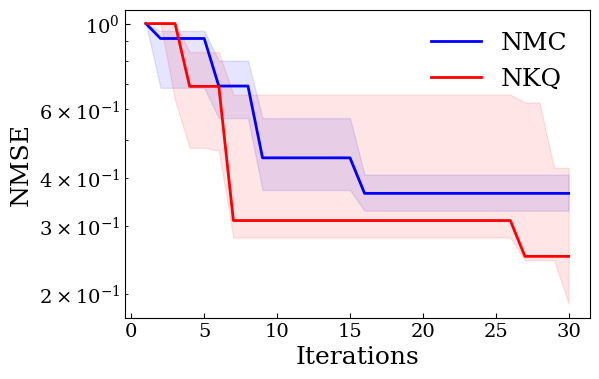

In [40]:
iter_array = np.arange(1, iter_num + 1)

fig1 = plt.figure(figsize=(6, 4))
plt.grid(False)
plt.plot(iter_array, I_nmc_median, label=f'NMC', color='blue')
plt.fill_between(iter_array, I_nmc_q25, I_nmc_q75, alpha=0.1, color='blue')
plt.plot(iter_array, I_nkq_median, label=f'NKQ', color='red')
plt.fill_between(iter_array, I_nkq_q25, I_nkq_q75, alpha=0.1, color='red')
plt.xlabel('Iterations')
plt.ylabel('NMSE')
plt.yscale('log')
plt.legend()

